In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from joblib import Parallel, delayed
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
from sklearn.cluster import DBSCAN
import time
plt.rcParams["font.family"] = "Times New Roman"
from GeoRefTool import *
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
def count(TSAv):
    temp_count = 0
    apear_ind = []
    counts = []
    for i in range(len(TSAv)):
        if (TSAv[i] == True):
            temp_count += 1
        else:
            if (i > 0) & (TSAv[i - 1] == True):
                apear_ind.append(i - temp_count)
                counts.append(temp_count)
                temp_count = 0
                counts.append(0)
            else:
                counts.append(0)
        if (i == len(TSAv) - 1) & (temp_count != 0):
            apear_ind.append(i - temp_count + 1)
            counts.append(temp_count)
    counts = np.array(counts)
    counts = counts[counts > 0]
    return np.array(counts), np.array(apear_ind)

In [3]:
def gen_xyz(dis,i,j):
    longitudes = theta[i]*np.pi / 180
    latitudes = azimuths[j] * np.pi / 180 
    hypotenuses = dis * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = dis * np.sin(longitudes)
    return np.array([X,Y,Z])

In [4]:
db = Raster_DBSCAN(window_size=[5,13],eps = 1.5,min_samples = 12,Td_map_szie = [32,1800])
dbscan = DBSCAN(eps = 1, min_samples = 20)

In [5]:
thred_map = np.load(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy')


In [11]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps\2022-1-22-11-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)
# thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.08,bck_n = 3 )
thred_map = np.load(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy')
thred_map = thred_map.max(axis = 0)
aggregated_Labeling_map = []
for i in tqdm(range(aggregated_map.shape[0])):
    Td_map = aggregated_map[i]
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 1.5).any(axis = 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    aggregated_Labeling_map.append(Labeling_map)
aggregated_Labeling_map = np.array(aggregated_Labeling_map)
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        foreground_ind = aggregated_Labeling_map[:,i,j] != -1
        if foreground_ind.any(): # foreground
            dis_values = aggregated_map[foreground_ind,i,j]
            labels = dbscan.fit_predict(dis_values.reshape(-1,1))
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[1:]
            if len(unique_labels) >= 1: 
                for l in unique_labels:
                    dis = np.mean(dis_values[labels == l])
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = (labels == l).sum()/len(foreground_ind)
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.3,
                                         ransac_n=10,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [1:21:02<00:00, 151.96s/it]


24.884
1309


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

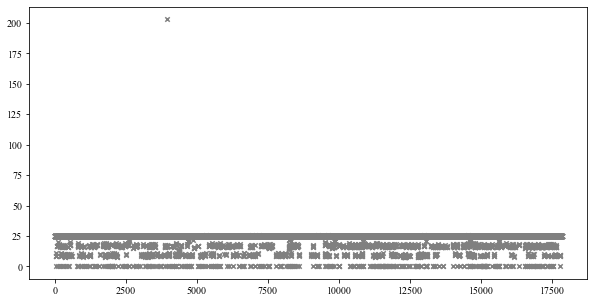

In [12]:
laser_id = 4
azimuth_channel = 1309
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,70)

# plt.xlim(2000,2400)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

## Large Bck Generator

In [6]:
def get_thred(temp,N = 10,d_thred = 0.1,bck_n = 3):
    temp = temp.copy()
    total_sample = len(temp)
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        ind = np.abs(temp - sample) < 0.3
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
        
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    
    if len(bck_ds_) <= bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-1 * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

In [7]:
def gen_bckmap(aggregated_maps, N, d_thred, bck_n):
    thred_map = np.zeros((bck_n,32,1800))
    for i in tqdm(range(thred_map.shape[1])):
        for j in range(thred_map.shape[2]):
            thred_map[:,i,j] = get_thred(aggregated_maps[:,i,j],N = N,d_thred = d_thred,bck_n = bck_n)
    return thred_map

In [15]:
f_path = r'D:\LiDAR_Data\MidTown\Larue\Agg'
agg_dirs = np.array(os.listdir(f_path))
hours = [eval(f.split('-')[3]) for f in agg_dirs]
agg_dirs = agg_dirs[np.argsort(hours)]

In [16]:
aggregated_maps = []
for f in tqdm(agg_dirs):
    aggregated_map = np.load(os.path.join(f_path,f))
    aggregated_maps.append(aggregated_map)
aggregated_maps = np.concatenate(aggregated_maps)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:41<00:00,  6.74s/it]


In [17]:
thred_map = gen_bckmap(aggregated_maps, N = 20,d_thred = 0.12,bck_n = 5)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [04:26<00:00,  8.34s/it]


In [18]:
np.save(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy',thred_map)

## Parking Test

In [4]:
thred_map = np.load(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy')

In [5]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps\2022-1-22-13-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)

 99%|███████████████████████████████████████████████████████████████████████████▎| 17847/18000 [11:55<00:06, 24.96it/s]


In [6]:
def get_parking(temp,N = 20,d_thred = 0.15,bck_n = 6):
    temp = temp.copy()
    total_sample = len(temp)
    temp = temp[temp > 0]
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        
        ind = np.abs(temp - sample) < 0.4
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
        
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    
    if len(bck_ds_) <= bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-1 * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

In [7]:
for i in range(aggregated_map.shape[1]):
    for j in range(aggregated_map.shape[2]):
        laser_id = i
        azimuth_channel = j
        temp = aggregated_map[:,laser_id,azimuth_channel].copy()
        thred = thred_map[:,laser_id,azimuth_channel]
        thred_max = thred.max()
        bck_inds = ((np.abs((temp - thred_max)) < 0.4))
        temp[bck_inds] = 0
        components = get_parking(temp,N = 20,d_thred = 0.15,bck_n = 6)
        if (components == -1).sum() < 6:
            print(i,j,'com',components)
            

1 398 com [ 8.464 -1.    -1.    -1.    -1.    -1.   ]
1 590 com [ 6.472 -1.    -1.    -1.    -1.    -1.   ]
1 597 com [ 7.14 -1.   -1.   -1.   -1.   -1.  ]
1 709 com [ 6.192 -1.    -1.    -1.    -1.    -1.   ]
1 885 com [ 5.952 -1.    -1.    -1.    -1.    -1.   ]
1 890 com [ 5.968 -1.    -1.    -1.    -1.    -1.   ]
1 1168 com [ 8.28 -1.   -1.   -1.   -1.   -1.  ]
1 1236 com [ 6.032 -1.    -1.    -1.    -1.    -1.   ]
2 389 com [11.48 -1.   -1.   -1.   -1.   -1.  ]
2 395 com [11.536 -1.    -1.    -1.    -1.    -1.   ]
2 568 com [ 6.424 -1.    -1.    -1.    -1.    -1.   ]
2 569 com [ 6.38 -1.   -1.   -1.   -1.   -1.  ]
2 570 com [ 6.38 -1.   -1.   -1.   -1.   -1.  ]
2 579 com [ 6.18 -1.   -1.   -1.   -1.   -1.  ]
2 581 com [ 6.428 -1.    -1.    -1.    -1.    -1.   ]
2 582 com [ 6.42 -1.   -1.   -1.   -1.   -1.  ]
2 587 com [ 6.428 -1.    -1.    -1.    -1.    -1.   ]
2 589 com [ 6.3 -1.  -1.  -1.  -1.  -1. ]
2 708 com [ 6.056 -1.    -1.    -1.    -1.    -1.   ]
2 882 com [10.584 -1.    -

4 893 com [10.636 -1.    -1.    -1.    -1.    -1.   ]
4 894 com [10.656 -1.    -1.    -1.    -1.    -1.   ]
4 895 com [10.664 -1.    -1.    -1.    -1.    -1.   ]
4 896 com [10.7 -1.  -1.  -1.  -1.  -1. ]
4 897 com [10.724 -1.    -1.    -1.    -1.    -1.   ]
4 898 com [10.76 -1.   -1.   -1.   -1.   -1.  ]
4 899 com [10.756 -1.    -1.    -1.    -1.    -1.   ]
4 900 com [10.848 -1.    -1.    -1.    -1.    -1.   ]
4 901 com [10.832 -1.    -1.    -1.    -1.    -1.   ]
4 902 com [10.872 -1.    -1.    -1.    -1.    -1.   ]
4 903 com [10.908 -1.    -1.    -1.    -1.    -1.   ]
4 904 com [10.944 -1.    -1.    -1.    -1.    -1.   ]
4 905 com [10.948 -1.    -1.    -1.    -1.    -1.   ]
4 906 com [11.036 -1.    -1.    -1.    -1.    -1.   ]
4 907 com [11.04 -1.   -1.   -1.   -1.   -1.  ]
4 908 com [11.128 -1.    -1.    -1.    -1.    -1.   ]
4 909 com [11.124 -1.    -1.    -1.    -1.    -1.   ]
4 910 com [11.132 -1.    -1.    -1.    -1.    -1.   ]
4 911 com [11.156 -1.    -1.    -1.    -1.    -1.   

5 1153 com [15.684 -1.    -1.    -1.    -1.    -1.   ]
5 1154 com [15.688 -1.    -1.    -1.    -1.    -1.   ]
5 1155 com [15.7 -1.  -1.  -1.  -1.  -1. ]
5 1156 com [15.708 -1.    -1.    -1.    -1.    -1.   ]
5 1157 com [15.72 -1.   -1.   -1.   -1.   -1.  ]
5 1158 com [15.736 -1.    -1.    -1.    -1.    -1.   ]
5 1159 com [15.76 -1.   -1.   -1.   -1.   -1.  ]
5 1160 com [15.768 -1.    -1.    -1.    -1.    -1.   ]
5 1161 com [15.792 -1.    -1.    -1.    -1.    -1.   ]
5 1162 com [15.808 -1.    -1.    -1.    -1.    -1.   ]
5 1163 com [15.86 -1.   -1.   -1.   -1.   -1.  ]
5 1164 com [15.888 -1.    -1.    -1.    -1.    -1.   ]
5 1165 com [15.912 -1.    -1.    -1.    -1.    -1.   ]
5 1166 com [15.948 -1.    -1.    -1.    -1.    -1.   ]
5 1167 com [16.024 -1.    -1.    -1.    -1.    -1.   ]
5 1172 com [30.48 -1.   -1.   -1.   -1.   -1.  ]
5 1184 com [30.34 -1.   -1.   -1.   -1.   -1.  ]
5 1285 com [14.488 -1.    -1.    -1.    -1.    -1.   ]
5 1287 com [14.46 -1.   -1.   -1.   -1.   -1.  ]
5 1

6 1380 com [33.468 29.096 -1.    -1.    -1.    -1.   ]
6 1390 com [33.292 -1.    -1.    -1.    -1.    -1.   ]
6 1391 com [29.856 -1.    -1.    -1.    -1.    -1.   ]
6 1396 com [31.224 -1.    -1.    -1.    -1.    -1.   ]
6 1406 com [32.912 -1.    -1.    -1.    -1.    -1.   ]
6 1408 com [34.4 -1.  -1.  -1.  -1.  -1. ]
6 1487 com [25.68 -1.   -1.   -1.   -1.   -1.  ]
6 1489 com [28.368 -1.    -1.    -1.    -1.    -1.   ]
6 1533 com [24.632 -1.    -1.    -1.    -1.    -1.   ]
6 1543 com [24.3 -1.  -1.  -1.  -1.  -1. ]
6 1545 com [19.448 -1.    -1.    -1.    -1.    -1.   ]
6 1548 com [19.44 -1.   -1.   -1.   -1.   -1.  ]
6 1568 com [16.2 -1.  -1.  -1.  -1.  -1. ]
6 1760 com [12.576 -1.    -1.    -1.    -1.    -1.   ]
7 1 com [24.392 -1.    -1.    -1.    -1.    -1.   ]
7 32 com [20.916 -1.    -1.    -1.    -1.    -1.   ]
7 33 com [20.792 -1.    -1.    -1.    -1.    -1.   ]
7 168 com [17.328 -1.    -1.    -1.    -1.    -1.   ]
7 197 com [19.352 -1.    -1.    -1.    -1.    -1.   ]
7 207 com [1

7 1288 com [28.94 -1.   -1.   -1.   -1.   -1.  ]
7 1289 com [29.044 40.548 -1.    -1.    -1.    -1.   ]
7 1291 com [30.524 -1.    -1.    -1.    -1.    -1.   ]
7 1292 com [40.516 -1.    -1.    -1.    -1.    -1.   ]
7 1293 com [30.208 -1.    -1.    -1.    -1.    -1.   ]
7 1294 com [30.008 -1.    -1.    -1.    -1.    -1.   ]
7 1297 com [28.276 -1.    -1.    -1.    -1.    -1.   ]
7 1304 com [40.276 -1.    -1.    -1.    -1.    -1.   ]
7 1307 com [25.828 40.084 -1.    -1.    -1.    -1.   ]
7 1308 com [25.792 -1.    -1.    -1.    -1.    -1.   ]
7 1309 com [28.404 32.276 -1.    -1.    -1.    -1.   ]
7 1310 com [28.088 -1.    -1.    -1.    -1.    -1.   ]
7 1311 com [28.108 -1.    -1.    -1.    -1.    -1.   ]
7 1312 com [28.076 -1.    -1.    -1.    -1.    -1.   ]
7 1314 com [28.252 -1.    -1.    -1.    -1.    -1.   ]
7 1315 com [28.408 -1.    -1.    -1.    -1.    -1.   ]
7 1316 com [28.404 -1.    -1.    -1.    -1.    -1.   ]
7 1317 com [26.912 -1.    -1.    -1.    -1.    -1.   ]
7 1318 com [27.0

8 967 com [12.22 -1.   -1.   -1.   -1.   -1.  ]
8 1011 com [18.416 -1.    -1.    -1.    -1.    -1.   ]
8 1021 com [18.62 -1.   -1.   -1.   -1.   -1.  ]
8 1022 com [24.636 -1.    -1.    -1.    -1.    -1.   ]
8 1033 com [20.744 -1.    -1.    -1.    -1.    -1.   ]
8 1040 com [21.92 -1.   -1.   -1.   -1.   -1.  ]
8 1043 com [22.436 -1.    -1.    -1.    -1.    -1.   ]
8 1047 com [24.82 -1.   -1.   -1.   -1.   -1.  ]
8 1048 com [23.928 -1.    -1.    -1.    -1.    -1.   ]
8 1063 com [27.724 -1.    -1.    -1.    -1.    -1.   ]
8 1078 com [53.156 -1.    -1.    -1.    -1.    -1.   ]
8 1092 com [53.96 -1.   -1.   -1.   -1.   -1.  ]
8 1100 com [54.552 -1.    -1.    -1.    -1.    -1.   ]
8 1101 com [15.796 -1.    -1.    -1.    -1.    -1.   ]
8 1111 com [15.468 -1.    -1.    -1.    -1.    -1.   ]
8 1112 com [26.032 38.044 -1.    -1.    -1.    -1.   ]
8 1114 com [15.632 -1.    -1.    -1.    -1.    -1.   ]
8 1115 com [16.092 -1.    -1.    -1.    -1.    -1.   ]
8 1116 com [38.052 -1.    -1.    -1.    -

9 315 com [13.084 -1.    -1.    -1.    -1.    -1.   ]
9 325 com [14.472 -1.    -1.    -1.    -1.    -1.   ]
9 328 com [14.44 -1.   -1.   -1.   -1.   -1.  ]
9 329 com [14.492 -1.    -1.    -1.    -1.    -1.   ]
9 399 com [17.624 -1.    -1.    -1.    -1.    -1.   ]
9 400 com [21.908 -1.    -1.    -1.    -1.    -1.   ]
9 403 com [17.88 -1.   -1.   -1.   -1.   -1.  ]
9 409 com [18.104 -1.    -1.    -1.    -1.    -1.   ]
9 416 com [23.064 -1.    -1.    -1.    -1.    -1.   ]
9 455 com [26.712 -1.    -1.    -1.    -1.    -1.   ]
9 478 com [22.816 -1.    -1.    -1.    -1.    -1.   ]
9 479 com [22.776 -1.    -1.    -1.    -1.    -1.   ]
9 480 com [22.796 -1.    -1.    -1.    -1.    -1.   ]
9 481 com [22.74 -1.   -1.   -1.   -1.   -1.  ]
9 482 com [22.596 -1.    -1.    -1.    -1.    -1.   ]
9 483 com [22.524 -1.    -1.    -1.    -1.    -1.   ]
9 484 com [22.504 -1.    -1.    -1.    -1.    -1.   ]
9 485 com [22.52 -1.   -1.   -1.   -1.   -1.  ]
9 486 com [22.364 -1.    -1.    -1.    -1.    -1.   

9 1167 com [65.592 -1.    -1.    -1.    -1.    -1.   ]
9 1168 com [65.416 -1.    -1.    -1.    -1.    -1.   ]
9 1169 com [65.244 -1.    -1.    -1.    -1.    -1.   ]
9 1170 com [65.24 -1.   -1.   -1.   -1.   -1.  ]
9 1171 com [65.12 -1.   -1.   -1.   -1.   -1.  ]
9 1172 com [64.644 -1.    -1.    -1.    -1.    -1.   ]
9 1174 com [64.204 -1.    -1.    -1.    -1.    -1.   ]
9 1191 com [63.272 62.124 -1.    -1.    -1.    -1.   ]
9 1192 com [61.996 -1.    -1.    -1.    -1.    -1.   ]
9 1200 com [52.26 -1.   -1.   -1.   -1.   -1.  ]
9 1202 com [51.392 -1.    -1.    -1.    -1.    -1.   ]
9 1203 com [50.956 -1.    -1.    -1.    -1.    -1.   ]
9 1204 com [50.688 -1.    -1.    -1.    -1.    -1.   ]
9 1205 com [50.264 -1.    -1.    -1.    -1.    -1.   ]
9 1207 com [49.236 -1.    -1.    -1.    -1.    -1.   ]
9 1208 com [49.124 -1.    -1.    -1.    -1.    -1.   ]
9 1210 com [48.188 -1.    -1.    -1.    -1.    -1.   ]
9 1211 com [48.064 -1.    -1.    -1.    -1.    -1.   ]
9 1245 com [ 6.008 -1.    -1

10 316 com [13.06 -1.   -1.   -1.   -1.   -1.  ]
10 364 com [19.512 -1.    -1.    -1.    -1.    -1.   ]
10 401 com [17.608 -1.    -1.    -1.    -1.    -1.   ]
10 409 com [18.104 -1.    -1.    -1.    -1.    -1.   ]
10 410 com [18.108 -1.    -1.    -1.    -1.    -1.   ]
10 455 com [26.708 -1.    -1.    -1.    -1.    -1.   ]
10 478 com [22.824 -1.    -1.    -1.    -1.    -1.   ]
10 479 com [22.824 -1.    -1.    -1.    -1.    -1.   ]
10 480 com [22.788 -1.    -1.    -1.    -1.    -1.   ]
10 481 com [22.68 -1.   -1.   -1.   -1.   -1.  ]
10 482 com [22.648 -1.    -1.    -1.    -1.    -1.   ]
10 483 com [22.628 -1.    -1.    -1.    -1.    -1.   ]
10 484 com [22.572 -1.    -1.    -1.    -1.    -1.   ]
10 485 com [22.496 -1.    -1.    -1.    -1.    -1.   ]
10 486 com [22.404 -1.    -1.    -1.    -1.    -1.   ]
10 487 com [22.36 -1.   -1.   -1.   -1.   -1.  ]
10 488 com [22.356 -1.    -1.    -1.    -1.    -1.   ]
10 489 com [22.284 -1.    -1.    -1.    -1.    -1.   ]
10 490 com [22.248 -1.    -1

10 972 com [12.96 -1.   -1.   -1.   -1.   -1.  ]
10 1021 com [18.3 -1.  -1.  -1.  -1.  -1. ]
10 1040 com [22.12 -1.   -1.   -1.   -1.   -1.  ]
10 1044 com [24.232 -1.    -1.    -1.    -1.    -1.   ]
10 1051 com [25.416 -1.    -1.    -1.    -1.    -1.   ]
10 1079 com [63.708 -1.    -1.    -1.    -1.    -1.   ]
10 1082 com [73.236 72.5   -1.    -1.    -1.    -1.   ]
10 1083 com [72.928 64.26  -1.    -1.    -1.    -1.   ]
10 1084 com [64.264 72.648 -1.    -1.    -1.    -1.   ]
10 1085 com [72.4   73.456 -1.    -1.    -1.    -1.   ]
10 1086 com [73.924 73.448 -1.    -1.    -1.    -1.   ]
10 1087 com [73.5   74.128 -1.    -1.    -1.    -1.   ]
10 1088 com [74.06 -1.   -1.   -1.   -1.   -1.  ]
10 1089 com [74.196 -1.    -1.    -1.    -1.    -1.   ]
10 1090 com [74.024 43.62  -1.    -1.    -1.    -1.   ]
10 1092 com [74.1 -1.  -1.  -1.  -1.  -1. ]
10 1093 com [74.7   65.908 75.132 -1.    -1.    -1.   ]
10 1094 com [74.364 75.216 42.496 -1.    -1.    -1.   ]
10 1095 com [42.44  74.956 -1.    -

11 55 com [33.028 -1.    -1.    -1.    -1.    -1.   ]
11 56 com [32.732 -1.    -1.    -1.    -1.    -1.   ]
11 57 com [32.632 -1.    -1.    -1.    -1.    -1.   ]
11 58 com [32.564 -1.    -1.    -1.    -1.    -1.   ]
11 59 com [32.532 -1.    -1.    -1.    -1.    -1.   ]
11 60 com [32.412 -1.    -1.    -1.    -1.    -1.   ]
11 61 com [32.292 -1.    -1.    -1.    -1.    -1.   ]
11 62 com [32.188 -1.    -1.    -1.    -1.    -1.   ]
11 63 com [32.164 -1.    -1.    -1.    -1.    -1.   ]
11 64 com [32.008 -1.    -1.    -1.    -1.    -1.   ]
11 65 com [31.964 -1.    -1.    -1.    -1.    -1.   ]
11 66 com [31.868 -1.    -1.    -1.    -1.    -1.   ]
11 67 com [31.824 -1.    -1.    -1.    -1.    -1.   ]
11 68 com [31.696 -1.    -1.    -1.    -1.    -1.   ]
11 69 com [31.588 -1.    -1.    -1.    -1.    -1.   ]
11 70 com [31.52 -1.   -1.   -1.   -1.   -1.  ]
11 71 com [31.584 -1.    -1.    -1.    -1.    -1.   ]
11 72 com [31.392 -1.    -1.    -1.    -1.    -1.   ]
11 73 com [31.256 -1.    -1.    -1

11 549 com [38.444 31.204 -1.    -1.    -1.    -1.   ]
11 550 com [38.536 31.312 -1.    -1.    -1.    -1.   ]
11 551 com [40.46  31.984 -1.    -1.    -1.    -1.   ]
11 552 com [40.948 32.296 -1.    -1.    -1.    -1.   ]
11 553 com [37.844 -1.    -1.    -1.    -1.    -1.   ]
11 554 com [37.78 -1.   -1.   -1.   -1.   -1.  ]
11 555 com [37.816 -1.    -1.    -1.    -1.    -1.   ]
11 556 com [37.86 -1.   -1.   -1.   -1.   -1.  ]
11 557 com [37.96 -1.   -1.   -1.   -1.   -1.  ]
11 558 com [37.712 -1.    -1.    -1.    -1.    -1.   ]
11 559 com [37.856 -1.    -1.    -1.    -1.    -1.   ]
11 560 com [38.112 -1.    -1.    -1.    -1.    -1.   ]
11 562 com [42.688 -1.    -1.    -1.    -1.    -1.   ]
11 563 com [42.56 -1.   -1.   -1.   -1.   -1.  ]
11 564 com [40.152 42.568 -1.    -1.    -1.    -1.   ]
11 565 com [40.348 -1.    -1.    -1.    -1.    -1.   ]
11 567 com [42.808 -1.    -1.    -1.    -1.    -1.   ]
11 568 com [42.892 -1.    -1.    -1.    -1.    -1.   ]
11 569 com [42.944 -1.    -1.    -

11 1183 com [63.056 -1.    -1.    -1.    -1.    -1.   ]
11 1185 com [65.212 -1.    -1.    -1.    -1.    -1.   ]
11 1189 com [63.124 -1.    -1.    -1.    -1.    -1.   ]
11 1190 com [63.064 62.428 -1.    -1.    -1.    -1.   ]
11 1191 com [62.264 -1.    -1.    -1.    -1.    -1.   ]
11 1192 com [61.848 -1.    -1.    -1.    -1.    -1.   ]
11 1219 com [ 5.792 -1.    -1.    -1.    -1.    -1.   ]
11 1246 com [ 6.052 -1.    -1.    -1.    -1.    -1.   ]
11 1250 com [35.868 -1.    -1.    -1.    -1.    -1.   ]
11 1251 com [35.692 -1.    -1.    -1.    -1.    -1.   ]
11 1265 com [53.656 -1.    -1.    -1.    -1.    -1.   ]
11 1266 com [53.848 32.904 -1.    -1.    -1.    -1.   ]
11 1271 com [32.636 -1.    -1.    -1.    -1.    -1.   ]
11 1287 com [14.436 30.352 -1.    -1.    -1.    -1.   ]
11 1294 com [58.996 -1.    -1.    -1.    -1.    -1.   ]
11 1295 com [49.04 -1.   -1.   -1.   -1.   -1.  ]
11 1305 com [48.884 -1.    -1.    -1.    -1.    -1.   ]
11 1308 com [25.76 -1.   -1.   -1.   -1.   -1.  ]
11 1

12 316 com [13.072 -1.    -1.    -1.    -1.    -1.   ]
12 403 com [21.98 -1.   -1.   -1.   -1.   -1.  ]
12 405 com [17.876 -1.    -1.    -1.    -1.    -1.   ]
12 411 com [18.144 -1.    -1.    -1.    -1.    -1.   ]
12 481 com [22.816 -1.    -1.    -1.    -1.    -1.   ]
12 482 com [22.744 -1.    -1.    -1.    -1.    -1.   ]
12 483 com [22.688 -1.    -1.    -1.    -1.    -1.   ]
12 484 com [22.64 -1.   -1.   -1.   -1.   -1.  ]
12 485 com [22.584 -1.    -1.    -1.    -1.    -1.   ]
12 486 com [22.476 -1.    -1.    -1.    -1.    -1.   ]
12 487 com [22.476 -1.    -1.    -1.    -1.    -1.   ]
12 488 com [22.38 -1.   -1.   -1.   -1.   -1.  ]
12 489 com [22.32 -1.   -1.   -1.   -1.   -1.  ]
12 490 com [22.3 -1.  -1.  -1.  -1.  -1. ]
12 491 com [22.272 -1.    -1.    -1.    -1.    -1.   ]
12 492 com [22.22 -1.   -1.   -1.   -1.   -1.  ]
12 493 com [22.192 -1.    -1.    -1.    -1.    -1.   ]
12 494 com [22.184 -1.    -1.    -1.    -1.    -1.   ]
12 495 com [22.152 -1.    -1.    -1.    -1.    -1.  

12 1021 com [19.684 -1.    -1.    -1.    -1.    -1.   ]
12 1022 com [19.68 -1.   -1.   -1.   -1.   -1.  ]
12 1023 com [19.14 -1.   -1.   -1.   -1.   -1.  ]
12 1033 com [19.48 -1.   -1.   -1.   -1.   -1.  ]
12 1040 com [21.744 -1.    -1.    -1.    -1.    -1.   ]
12 1041 com [22.284 -1.    -1.    -1.    -1.    -1.   ]
12 1078 com [55.788 -1.    -1.    -1.    -1.    -1.   ]
12 1081 com [73.024 -1.    -1.    -1.    -1.    -1.   ]
12 1083 com [78.476 -1.    -1.    -1.    -1.    -1.   ]
12 1084 com [64.304 -1.    -1.    -1.    -1.    -1.   ]
12 1085 com [86.204 -1.    -1.    -1.    -1.    -1.   ]
12 1086 com [106.18  109.012  -1.     -1.     -1.     -1.   ]
12 1087 com [118.036  -1.     -1.     -1.     -1.     -1.   ]
12 1088 com [118.06  -1.    -1.    -1.    -1.    -1.  ]
12 1089 com [118.356 117.736  -1.     -1.     -1.     -1.   ]
12 1090 com [118.256  -1.     -1.     -1.     -1.     -1.   ]
12 1092 com [43.596 -1.    -1.    -1.    -1.    -1.   ]
12 1093 com [118.108  -1.     -1.     -1. 

12 1760 com [12.532 -1.    -1.    -1.    -1.    -1.   ]
12 1782 com [31.536 -1.    -1.    -1.    -1.    -1.   ]
12 1783 com [30.94 31.64 -1.   -1.   -1.   -1.  ]
13 38 com [31.292 35.844 -1.    -1.    -1.    -1.   ]
13 40 com [35.828 -1.    -1.    -1.    -1.    -1.   ]
13 41 com [35.856 -1.    -1.    -1.    -1.    -1.   ]
13 42 com [35.796 -1.    -1.    -1.    -1.    -1.   ]
13 43 com [35.816 -1.    -1.    -1.    -1.    -1.   ]
13 44 com [35.776 -1.    -1.    -1.    -1.    -1.   ]
13 45 com [35.704 -1.    -1.    -1.    -1.    -1.   ]
13 46 com [35.764 -1.    -1.    -1.    -1.    -1.   ]
13 47 com [35.768 -1.    -1.    -1.    -1.    -1.   ]
13 53 com [35.844 -1.    -1.    -1.    -1.    -1.   ]
13 56 com [35.648 -1.    -1.    -1.    -1.    -1.   ]
13 57 com [35.588 -1.    -1.    -1.    -1.    -1.   ]
13 58 com [35.56 -1.   -1.   -1.   -1.   -1.  ]
13 59 com [35.496 -1.    -1.    -1.    -1.    -1.   ]
13 60 com [35.516 -1.    -1.    -1.    -1.    -1.   ]
13 61 com [35.56 -1.   -1.   -1.  

13 531 com [30.42 -1.   -1.   -1.   -1.   -1.  ]
13 532 com [30.072 -1.    -1.    -1.    -1.    -1.   ]
13 533 com [30.308 35.364 -1.    -1.    -1.    -1.   ]
13 534 com [30.216 -1.    -1.    -1.    -1.    -1.   ]
13 535 com [30.18 -1.   -1.   -1.   -1.   -1.  ]
13 536 com [30.008 45.684 -1.    -1.    -1.    -1.   ]
13 537 com [30.112 -1.    -1.    -1.    -1.    -1.   ]
13 538 com [48.292 30.056 -1.    -1.    -1.    -1.   ]
13 539 com [48.38 30.12 -1.   -1.   -1.   -1.  ]
13 540 com [48.588 30.156 -1.    -1.    -1.    -1.   ]
13 541 com [48.68  30.204 -1.    -1.    -1.    -1.   ]
13 542 com [48.848 30.    -1.    -1.    -1.    -1.   ]
13 543 com [49.132 30.156 -1.    -1.    -1.    -1.   ]
13 544 com [49.024 30.268 -1.    -1.    -1.    -1.   ]
13 545 com [30.444 -1.    -1.    -1.    -1.    -1.   ]
13 546 com [41.44 30.6  -1.   -1.   -1.   -1.  ]
13 547 com [30.756 37.692 -1.    -1.    -1.    -1.   ]
13 548 com [37.716 31.068 -1.    -1.    -1.    -1.   ]
13 549 com [37.636 31.308 -1.    -

13 1159 com [77.624 -1.    -1.    -1.    -1.    -1.   ]
13 1160 com [76.608 -1.    -1.    -1.    -1.    -1.   ]
13 1165 com [62.984 -1.    -1.    -1.    -1.    -1.   ]
13 1166 com [63.008 -1.    -1.    -1.    -1.    -1.   ]
13 1176 com [71.408 -1.    -1.    -1.    -1.    -1.   ]
13 1177 com [63.472 -1.    -1.    -1.    -1.    -1.   ]
13 1179 com [63.156 -1.    -1.    -1.    -1.    -1.   ]
13 1182 com [66.544 -1.    -1.    -1.    -1.    -1.   ]
13 1184 com [65.46 -1.   -1.   -1.   -1.   -1.  ]
13 1193 com [53.672 77.008 -1.    -1.    -1.    -1.   ]
13 1196 com [79.66 -1.   -1.   -1.   -1.   -1.  ]
13 1197 com [59.464 -1.    -1.    -1.    -1.    -1.   ]
13 1199 com [58.344 -1.    -1.    -1.    -1.    -1.   ]
13 1200 com [58.336 53.788 -1.    -1.    -1.    -1.   ]
13 1201 com [53.808 -1.    -1.    -1.    -1.    -1.   ]
13 1203 com [56.736 -1.    -1.    -1.    -1.    -1.   ]
13 1204 com [80.608 56.7   -1.    -1.    -1.    -1.   ]
13 1245 com [ 6.04 -1.   -1.   -1.   -1.   -1.  ]
13 1266 co

14 115 com [37.228 -1.    -1.    -1.    -1.    -1.   ]
14 116 com [37.268 -1.    -1.    -1.    -1.    -1.   ]
14 117 com [37.232 -1.    -1.    -1.    -1.    -1.   ]
14 118 com [37.32 -1.   -1.   -1.   -1.   -1.  ]
14 119 com [37.428 -1.    -1.    -1.    -1.    -1.   ]
14 120 com [37.38 -1.   -1.   -1.   -1.   -1.  ]
14 121 com [37.32 -1.   -1.   -1.   -1.   -1.  ]
14 122 com [37.476 -1.    -1.    -1.    -1.    -1.   ]
14 123 com [37.46 -1.   -1.   -1.   -1.   -1.  ]
14 124 com [37.564 -1.    -1.    -1.    -1.    -1.   ]
14 125 com [37.664 -1.    -1.    -1.    -1.    -1.   ]
14 126 com [37.544 -1.    -1.    -1.    -1.    -1.   ]
14 127 com [37.62 -1.   -1.   -1.   -1.   -1.  ]
14 128 com [37.812 -1.    -1.    -1.    -1.    -1.   ]
14 129 com [37.748 -1.    -1.    -1.    -1.    -1.   ]
14 130 com [37.688 -1.    -1.    -1.    -1.    -1.   ]
14 132 com [37.836 -1.    -1.    -1.    -1.    -1.   ]
14 135 com [37.932 -1.    -1.    -1.    -1.    -1.   ]
14 136 com [37.884 -1.    -1.    -1.    

14 606 com [64.176 -1.    -1.    -1.    -1.    -1.   ]
14 607 com [63.888 -1.    -1.    -1.    -1.    -1.   ]
14 608 com [64.088 -1.    -1.    -1.    -1.    -1.   ]
14 609 com [64.18 -1.   -1.   -1.   -1.   -1.  ]
14 610 com [64.368 64.912 -1.    -1.    -1.    -1.   ]
14 611 com [64.716 -1.    -1.    -1.    -1.    -1.   ]
14 612 com [65.04 -1.   -1.   -1.   -1.   -1.  ]
14 613 com [65.284 -1.    -1.    -1.    -1.    -1.   ]
14 614 com [65.688 -1.    -1.    -1.    -1.    -1.   ]
14 615 com [65.964 -1.    -1.    -1.    -1.    -1.   ]
14 616 com [66.24 -1.   -1.   -1.   -1.   -1.  ]
14 617 com [66.328 -1.    -1.    -1.    -1.    -1.   ]
14 618 com [66.88 -1.   -1.   -1.   -1.   -1.  ]
14 619 com [67.292 -1.    -1.    -1.    -1.    -1.   ]
14 620 com [67.544 -1.    -1.    -1.    -1.    -1.   ]
14 621 com [68.008 -1.    -1.    -1.    -1.    -1.   ]
14 622 com [39.628 -1.    -1.    -1.    -1.    -1.   ]
14 623 com [39.728 37.9   -1.    -1.    -1.    -1.   ]
14 624 com [37.752 -1.    -1.    -

14 1335 com [52.264 -1.    -1.    -1.    -1.    -1.   ]
14 1336 com [52.088 -1.    -1.    -1.    -1.    -1.   ]
14 1337 com [50.892 -1.    -1.    -1.    -1.    -1.   ]
14 1338 com [50.764 -1.    -1.    -1.    -1.    -1.   ]
14 1339 com [51.56 -1.   -1.   -1.   -1.   -1.  ]
14 1340 com [51.516 -1.    -1.    -1.    -1.    -1.   ]
14 1342 com [52.056 -1.    -1.    -1.    -1.    -1.   ]
14 1343 com [52.184 -1.    -1.    -1.    -1.    -1.   ]
14 1344 com [52.26 -1.   -1.   -1.   -1.   -1.  ]
14 1346 com [52.896 -1.    -1.    -1.    -1.    -1.   ]
14 1351 com [72.112 -1.    -1.    -1.    -1.    -1.   ]
14 1353 com [72.012 -1.    -1.    -1.    -1.    -1.   ]
14 1354 com [71.884 38.308 -1.    -1.    -1.    -1.   ]
14 1355 com [37.376 71.624 -1.    -1.    -1.    -1.   ]
14 1358 com [70.932 -1.    -1.    -1.    -1.    -1.   ]
14 1369 com [69.436 -1.    -1.    -1.    -1.    -1.   ]
14 1379 com [68.184 -1.    -1.    -1.    -1.    -1.   ]
14 1387 com [68.472 29.924 -1.    -1.    -1.    -1.   ]
14 1

15 96 com [46.004 -1.    -1.    -1.    -1.    -1.   ]
15 97 com [45.58 46.06 -1.   -1.   -1.   -1.  ]
15 98 com [45.748 -1.    -1.    -1.    -1.    -1.   ]
15 99 com [45.624 -1.    -1.    -1.    -1.    -1.   ]
15 100 com [45.48 -1.   -1.   -1.   -1.   -1.  ]
15 101 com [45.232 -1.    -1.    -1.    -1.    -1.   ]
15 102 com [44.988 -1.    -1.    -1.    -1.    -1.   ]
15 103 com [44.528 45.124 -1.    -1.    -1.    -1.   ]
15 104 com [44.568 -1.    -1.    -1.    -1.    -1.   ]
15 105 com [44.488 -1.    -1.    -1.    -1.    -1.   ]
15 106 com [44.416 -1.    -1.    -1.    -1.    -1.   ]
15 107 com [44.252 -1.    -1.    -1.    -1.    -1.   ]
15 108 com [44.02 -1.   -1.   -1.   -1.   -1.  ]
15 109 com [44.048 -1.    -1.    -1.    -1.    -1.   ]
15 110 com [39.884 -1.    -1.    -1.    -1.    -1.   ]
15 111 com [40.088 -1.    -1.    -1.    -1.    -1.   ]
15 112 com [40.316 -1.    -1.    -1.    -1.    -1.   ]
15 113 com [40.584 -1.    -1.    -1.    -1.    -1.   ]
15 114 com [41.032 -1.    -1.   

15 555 com [38.352 -1.    -1.    -1.    -1.    -1.   ]
15 556 com [38.384 -1.    -1.    -1.    -1.    -1.   ]
15 557 com [38.348 -1.    -1.    -1.    -1.    -1.   ]
15 558 com [38.432 -1.    -1.    -1.    -1.    -1.   ]
15 560 com [38.512 -1.    -1.    -1.    -1.    -1.   ]
15 561 com [38.58 -1.   -1.   -1.   -1.   -1.  ]
15 562 com [38.596 -1.    -1.    -1.    -1.    -1.   ]
15 563 com [39.512 -1.    -1.    -1.    -1.    -1.   ]
15 564 com [40.12 -1.   -1.   -1.   -1.   -1.  ]
15 565 com [40.36 -1.   -1.   -1.   -1.   -1.  ]
15 566 com [40.888 69.192 -1.    -1.    -1.    -1.   ]
15 567 com [69.136 -1.    -1.    -1.    -1.    -1.   ]
15 568 com [69.092 -1.    -1.    -1.    -1.    -1.   ]
15 570 com [69.116 -1.    -1.    -1.    -1.    -1.   ]
15 571 com [69.268 -1.    -1.    -1.    -1.    -1.   ]
15 572 com [69.452 -1.    -1.    -1.    -1.    -1.   ]
15 573 com [51.02 -1.   -1.   -1.   -1.   -1.  ]
15 574 com [50.876 -1.    -1.    -1.    -1.    -1.   ]
15 575 com [50.816 -1.    -1.    -

15 1198 com [79.884 -1.    -1.    -1.    -1.    -1.   ]
15 1199 com [77.564 -1.    -1.    -1.    -1.    -1.   ]
15 1210 com [80.12 -1.   -1.   -1.   -1.   -1.  ]
15 1212 com [80.192 -1.    -1.    -1.    -1.    -1.   ]
15 1222 com [81.772 -1.    -1.    -1.    -1.    -1.   ]
15 1223 com [81.748 83.22  -1.    -1.    -1.    -1.   ]
15 1224 com [83.348 -1.    -1.    -1.    -1.    -1.   ]
15 1230 com [38.652 -1.    -1.    -1.    -1.    -1.   ]
15 1231 com [ 5.892 -1.    -1.    -1.    -1.    -1.   ]
15 1234 com [ 5.84 -1.   -1.   -1.   -1.   -1.  ]
15 1260 com [89.852 34.496 -1.    -1.    -1.    -1.   ]
15 1269 com [32.352 -1.    -1.    -1.    -1.    -1.   ]
15 1277 com [85.728 -1.    -1.    -1.    -1.    -1.   ]
15 1278 com [29.916 -1.    -1.    -1.    -1.    -1.   ]
15 1282 com [14.672 -1.    -1.    -1.    -1.    -1.   ]
15 1316 com [29.716 -1.    -1.    -1.    -1.    -1.   ]
15 1321 com [63.732 -1.    -1.    -1.    -1.    -1.   ]
15 1322 com [63.484 -1.    -1.    -1.    -1.    -1.   ]
15 1

16 125 com [45.508 -1.    -1.    -1.    -1.    -1.   ]
16 126 com [45.468 -1.    -1.    -1.    -1.    -1.   ]
16 127 com [45.5 -1.  -1.  -1.  -1.  -1. ]
16 128 com [45.56 -1.   -1.   -1.   -1.   -1.  ]
16 129 com [45.592 -1.    -1.    -1.    -1.    -1.   ]
16 130 com [45.644 -1.    -1.    -1.    -1.    -1.   ]
16 131 com [45.756 -1.    -1.    -1.    -1.    -1.   ]
16 132 com [45.756 -1.    -1.    -1.    -1.    -1.   ]
16 133 com [45.788 -1.    -1.    -1.    -1.    -1.   ]
16 134 com [45.92 -1.   -1.   -1.   -1.   -1.  ]
16 135 com [45.92 -1.   -1.   -1.   -1.   -1.  ]
16 136 com [45.968 -1.    -1.    -1.    -1.    -1.   ]
16 137 com [45.936 -1.    -1.    -1.    -1.    -1.   ]
16 138 com [46.092 -1.    -1.    -1.    -1.    -1.   ]
16 139 com [46.196 -1.    -1.    -1.    -1.    -1.   ]
16 140 com [46.08 -1.   -1.   -1.   -1.   -1.  ]
16 141 com [46.268 -1.    -1.    -1.    -1.    -1.   ]
16 143 com [46.12 -1.   -1.   -1.   -1.   -1.  ]
16 144 com [46.288 -1.    -1.    -1.    -1.    -1.  

16 607 com [98.532 -1.    -1.    -1.    -1.    -1.   ]
16 608 com [98.332 98.736 -1.    -1.    -1.    -1.   ]
16 609 com [98.936 98.532 -1.    -1.    -1.    -1.   ]
16 610 com [98.796 99.536 -1.    -1.    -1.    -1.   ]
16 611 com [99.336 -1.    -1.    -1.    -1.    -1.   ]
16 612 com [99.532 -1.    -1.    -1.    -1.    -1.   ]
16 613 com [99.352 -1.    -1.    -1.    -1.    -1.   ]
16 625 com [106.892  -1.     -1.     -1.     -1.     -1.   ]
16 626 com [106.88  -1.    -1.    -1.    -1.    -1.  ]
16 627 com [106.896  -1.     -1.     -1.     -1.     -1.   ]
16 628 com [106.824  55.92   -1.     -1.     -1.     -1.   ]
16 629 com [55.576 -1.    -1.    -1.    -1.    -1.   ]
16 630 com [55.7 -1.  -1.  -1.  -1.  -1. ]
16 631 com [55.528 -1.    -1.    -1.    -1.    -1.   ]
16 632 com [55.704 -1.    -1.    -1.    -1.    -1.   ]
16 633 com [55.576 -1.    -1.    -1.    -1.    -1.   ]
16 634 com [55.644 -1.    -1.    -1.    -1.    -1.   ]
16 635 com [55.576 -1.    -1.    -1.    -1.    -1.   ]
16 6

16 1390 com [29.116 -1.    -1.    -1.    -1.    -1.   ]
16 1391 com [29.084 -1.    -1.    -1.    -1.    -1.   ]
16 1395 com [29.628 -1.    -1.    -1.    -1.    -1.   ]
16 1396 com [29.596 -1.    -1.    -1.    -1.    -1.   ]
16 1399 com [31.12 -1.   -1.   -1.   -1.   -1.  ]
16 1409 com [67.872 -1.    -1.    -1.    -1.    -1.   ]
16 1415 com [91.908 -1.    -1.    -1.    -1.    -1.   ]
16 1416 com [68.536 -1.    -1.    -1.    -1.    -1.   ]
16 1417 com [68.58 -1.   -1.   -1.   -1.   -1.  ]
16 1419 com [68.264 -1.    -1.    -1.    -1.    -1.   ]
16 1420 com [68.244 -1.    -1.    -1.    -1.    -1.   ]
16 1422 com [40.004 -1.    -1.    -1.    -1.    -1.   ]
16 1423 com [39.552 -1.    -1.    -1.    -1.    -1.   ]
16 1442 com [39.024 -1.    -1.    -1.    -1.    -1.   ]
16 1443 com [39.964 -1.    -1.    -1.    -1.    -1.   ]
16 1444 com [40.496 -1.    -1.    -1.    -1.    -1.   ]
16 1445 com [41.204 -1.    -1.    -1.    -1.    -1.   ]
16 1450 com [42.784 -1.    -1.    -1.    -1.    -1.   ]
16 1

17 143 com [51.38 -1.   -1.   -1.   -1.   -1.  ]
17 144 com [51.26 -1.   -1.   -1.   -1.   -1.  ]
17 145 com [51.088 -1.    -1.    -1.    -1.    -1.   ]
17 147 com [51.46 -1.   -1.   -1.   -1.   -1.  ]
17 148 com [51.468 -1.    -1.    -1.    -1.    -1.   ]
17 149 com [51.416 -1.    -1.    -1.    -1.    -1.   ]
17 150 com [51.412 -1.    -1.    -1.    -1.    -1.   ]
17 151 com [51.736 -1.    -1.    -1.    -1.    -1.   ]
17 152 com [51.768 -1.    -1.    -1.    -1.    -1.   ]
17 153 com [51.588 -1.    -1.    -1.    -1.    -1.   ]
17 154 com [51.776 -1.    -1.    -1.    -1.    -1.   ]
17 155 com [51.868 -1.    -1.    -1.    -1.    -1.   ]
17 156 com [51.692 -1.    -1.    -1.    -1.    -1.   ]
17 157 com [24.948 -1.    -1.    -1.    -1.    -1.   ]
17 158 com [24.924 -1.    -1.    -1.    -1.    -1.   ]
17 162 com [52.308 -1.    -1.    -1.    -1.    -1.   ]
17 163 com [52.276 -1.    -1.    -1.    -1.    -1.   ]
17 166 com [24.532 -1.    -1.    -1.    -1.    -1.   ]
17 167 com [21.896 -1.    -1

17 680 com [53.484 -1.    -1.    -1.    -1.    -1.   ]
17 681 com [52.176 52.788 -1.    -1.    -1.    -1.   ]
17 682 com [52.168 -1.    -1.    -1.    -1.    -1.   ]
17 683 com [52.2 -1.  -1.  -1.  -1.  -1. ]
17 684 com [52.228 -1.    -1.    -1.    -1.    -1.   ]
17 685 com [52.28 -1.   -1.   -1.   -1.   -1.  ]
17 686 com [52.352 -1.    -1.    -1.    -1.    -1.   ]
17 687 com [52.4 -1.  -1.  -1.  -1.  -1. ]
17 688 com [52.404 58.86  -1.    -1.    -1.    -1.   ]
17 689 com [58.784 -1.    -1.    -1.    -1.    -1.   ]
17 690 com [58.988 59.568 -1.    -1.    -1.    -1.   ]
17 691 com [58.844 59.684 -1.    -1.    -1.    -1.   ]
17 692 com [58.932 -1.    -1.    -1.    -1.    -1.   ]
17 693 com [58.476 -1.    -1.    -1.    -1.    -1.   ]
17 696 com [58.672 59.288 -1.    -1.    -1.    -1.   ]
17 697 com [58.428 -1.    -1.    -1.    -1.    -1.   ]
17 699 com [26.236 -1.    -1.    -1.    -1.    -1.   ]
17 700 com [26.1 -1.  -1.  -1.  -1.  -1. ]
17 701 com [26.056 -1.    -1.    -1.    -1.    -1.  

17 1507 com [65.076 -1.    -1.    -1.    -1.    -1.   ]
17 1508 com [65.028 63.18  -1.    -1.    -1.    -1.   ]
17 1509 com [63.14 -1.   -1.   -1.   -1.   -1.  ]
17 1510 com [63.18 -1.   -1.   -1.   -1.   -1.  ]
17 1511 com [63.144 -1.    -1.    -1.    -1.    -1.   ]
17 1512 com [63.084 -1.    -1.    -1.    -1.    -1.   ]
17 1513 com [63.08 -1.   -1.   -1.   -1.   -1.  ]
17 1514 com [63.184 -1.    -1.    -1.    -1.    -1.   ]
17 1515 com [63.184 -1.    -1.    -1.    -1.    -1.   ]
17 1516 com [63.064 -1.    -1.    -1.    -1.    -1.   ]
17 1517 com [64.976 64.008 -1.    -1.    -1.    -1.   ]
17 1518 com [64.676 -1.    -1.    -1.    -1.    -1.   ]
17 1519 com [102.072  -1.     -1.     -1.     -1.     -1.   ]
17 1520 com [102.076  83.468  -1.     -1.     -1.     -1.   ]
17 1521 com [101.944  -1.     -1.     -1.     -1.     -1.   ]
17 1522 com [101.936  -1.     -1.     -1.     -1.     -1.   ]
17 1523 com [101.952  -1.     -1.     -1.     -1.     -1.   ]
17 1524 com [101.932  -1.     -1.   

18 316 com [13.064 -1.    -1.    -1.    -1.    -1.   ]
18 402 com [21.908 -1.    -1.    -1.    -1.    -1.   ]
18 406 com [17.288 -1.    -1.    -1.    -1.    -1.   ]
18 408 com [18.228 -1.    -1.    -1.    -1.    -1.   ]
18 409 com [18.232 17.416 -1.    -1.    -1.    -1.   ]
18 410 com [17.772 -1.    -1.    -1.    -1.    -1.   ]
18 417 com [23.008 -1.    -1.    -1.    -1.    -1.   ]
18 433 com [24.556 32.432 -1.    -1.    -1.    -1.   ]
18 434 com [24.636 -1.    -1.    -1.    -1.    -1.   ]
18 435 com [24.728 -1.    -1.    -1.    -1.    -1.   ]
18 436 com [24.788 -1.    -1.    -1.    -1.    -1.   ]
18 437 com [24.94 -1.   -1.   -1.   -1.   -1.  ]
18 441 com [25.292 -1.    -1.    -1.    -1.    -1.   ]
18 445 com [25.796 -1.    -1.    -1.    -1.    -1.   ]
18 455 com [26.632 -1.    -1.    -1.    -1.    -1.   ]
18 490 com [23.388 -1.    -1.    -1.    -1.    -1.   ]
18 491 com [23.3 -1.  -1.  -1.  -1.  -1. ]
18 492 com [23.212 -1.    -1.    -1.    -1.    -1.   ]
18 493 com [23.324 -1.    -1

18 1228 com [ 5.764 -1.    -1.    -1.    -1.    -1.   ]
18 1236 com [ 5.932 -1.    -1.    -1.    -1.    -1.   ]
18 1238 com [38.192 -1.    -1.    -1.    -1.    -1.   ]
18 1239 com [38.156 -1.    -1.    -1.    -1.    -1.   ]
18 1240 com [37.9 -1.  -1.  -1.  -1.  -1. ]
18 1241 com [37.644 -1.    -1.    -1.    -1.    -1.   ]
18 1242 com [37.424 -1.    -1.    -1.    -1.    -1.   ]
18 1260 com [34.444 -1.    -1.    -1.    -1.    -1.   ]
18 1267 com [89.928 32.564 -1.    -1.    -1.    -1.   ]
18 1272 com [32.656 -1.    -1.    -1.    -1.    -1.   ]
18 1273 com [87.66 -1.   -1.   -1.   -1.   -1.  ]
18 1274 com [86.7 -1.  -1.  -1.  -1.  -1. ]
18 1297 com [77.016 -1.    -1.    -1.    -1.    -1.   ]
18 1317 com [71.476 -1.    -1.    -1.    -1.    -1.   ]
18 1318 com [71.532 -1.    -1.    -1.    -1.    -1.   ]
18 1332 com [25.316 -1.    -1.    -1.    -1.    -1.   ]
18 1349 com [80.94 -1.   -1.   -1.   -1.   -1.  ]
18 1375 com [72.152 -1.    -1.    -1.    -1.    -1.   ]
18 1377 com [72.132 -1.    -

19 138 com [73.096 74.724 -1.    -1.    -1.    -1.   ]
19 139 com [74.868 -1.    -1.    -1.    -1.    -1.   ]
19 140 com [72.396 74.804 -1.    -1.    -1.    -1.   ]
19 141 com [71.892 72.496 -1.    -1.    -1.    -1.   ]
19 142 com [71.296 72.096 -1.    -1.    -1.    -1.   ]
19 143 com [71.1 -1.  -1.  -1.  -1.  -1. ]
19 144 com [70.604 -1.    -1.    -1.    -1.    -1.   ]
19 145 com [70.664 -1.    -1.    -1.    -1.    -1.   ]
19 146 com [70.068 -1.    -1.    -1.    -1.    -1.   ]
19 147 com [70.312 -1.    -1.    -1.    -1.    -1.   ]
19 148 com [70.04 -1.   -1.   -1.   -1.   -1.  ]
19 149 com [70.064 -1.    -1.    -1.    -1.    -1.   ]
19 150 com [70.3 -1.  -1.  -1.  -1.  -1. ]
19 151 com [69.884 -1.    -1.    -1.    -1.    -1.   ]
19 152 com [61.32 -1.   -1.   -1.   -1.   -1.  ]
19 153 com [68.572 -1.    -1.    -1.    -1.    -1.   ]
19 154 com [65.808 67.852 -1.    -1.    -1.    -1.   ]
19 155 com [65.872 66.604 -1.    -1.    -1.    -1.   ]
19 156 com [68.1 66.2 -1.  -1.  -1.  -1. ]
19 

19 1199 com [78.808 -1.    -1.    -1.    -1.    -1.   ]
19 1211 com [80.18 -1.   -1.   -1.   -1.   -1.  ]
19 1221 com [37.868 -1.    -1.    -1.    -1.    -1.   ]
19 1224 com [37.128 -1.    -1.    -1.    -1.    -1.   ]
19 1225 com [36.928 -1.    -1.    -1.    -1.    -1.   ]
19 1226 com [ 5.86 -1.   -1.   -1.   -1.   -1.  ]
19 1227 com [ 5.88 -1.   -1.   -1.   -1.   -1.  ]
19 1229 com [ 5.872 -1.    -1.    -1.    -1.    -1.   ]
19 1238 com [ 5.956 -1.    -1.    -1.    -1.    -1.   ]
19 1240 com [33.364 -1.    -1.    -1.    -1.    -1.   ]
19 1278 com [29.944 -1.    -1.    -1.    -1.    -1.   ]
19 1293 com [79.872 -1.    -1.    -1.    -1.    -1.   ]
19 1297 com [77.04 -1.   -1.   -1.   -1.   -1.  ]
19 1312 com [74.616 -1.    -1.    -1.    -1.    -1.   ]
19 1317 com [71.516 -1.    -1.    -1.    -1.    -1.   ]
19 1318 com [71.7 -1.  -1.  -1.  -1.  -1. ]
19 1332 com [25.34 -1.   -1.   -1.   -1.   -1.  ]
19 1360 com [96.848 -1.    -1.    -1.    -1.    -1.   ]
19 1361 com [97.008 -1.    -1.    

20 127 com [83.076 -1.    -1.    -1.    -1.    -1.   ]
20 128 com [83.168 -1.    -1.    -1.    -1.    -1.   ]
20 129 com [83.132 -1.    -1.    -1.    -1.    -1.   ]
20 131 com [53.184 -1.    -1.    -1.    -1.    -1.   ]
20 132 com [83.948 -1.    -1.    -1.    -1.    -1.   ]
20 133 com [84.396 -1.    -1.    -1.    -1.    -1.   ]
20 134 com [84.86 -1.   -1.   -1.   -1.   -1.  ]
20 135 com [85.028 -1.    -1.    -1.    -1.    -1.   ]
20 136 com [85.288 -1.    -1.    -1.    -1.    -1.   ]
20 137 com [86.124 85.7   -1.    -1.    -1.    -1.   ]
20 138 com [85.32  86.096 -1.    -1.    -1.    -1.   ]
20 139 com [84.624 85.196 -1.    -1.    -1.    -1.   ]
20 140 com [84.692 -1.    -1.    -1.    -1.    -1.   ]
20 141 com [84.588 -1.    -1.    -1.    -1.    -1.   ]
20 142 com [84.26 -1.   -1.   -1.   -1.   -1.  ]
20 143 com [83.764 -1.    -1.    -1.    -1.    -1.   ]
20 144 com [83.384 -1.    -1.    -1.    -1.    -1.   ]
20 145 com [83.136 82.66  -1.    -1.    -1.    -1.   ]
20 146 com [82.864 82.

20 1222 com [81.92 -1.   -1.   -1.   -1.   -1.  ]
20 1223 com [83.104 -1.    -1.    -1.    -1.    -1.   ]
20 1224 com [ 5.788 -1.    -1.    -1.    -1.    -1.   ]
20 1227 com [ 5.82 -1.   -1.   -1.   -1.   -1.  ]
20 1229 com [ 5.84 -1.   -1.   -1.   -1.   -1.  ]
20 1239 com [ 5.94 -1.   -1.   -1.   -1.   -1.  ]
20 1241 com [35.496 -1.    -1.    -1.    -1.    -1.   ]
20 1251 com [31.46 -1.   -1.   -1.   -1.   -1.  ]
20 1272 com [32.424 -1.    -1.    -1.    -1.    -1.   ]
20 1274 com [86.828 -1.    -1.    -1.    -1.    -1.   ]
20 1277 com [85.524 -1.    -1.    -1.    -1.    -1.   ]
20 1282 com [14.688 -1.    -1.    -1.    -1.    -1.   ]
20 1294 com [79.568 -1.    -1.    -1.    -1.    -1.   ]
20 1298 com [77.064 -1.    -1.    -1.    -1.    -1.   ]
20 1307 com [74.204 -1.    -1.    -1.    -1.    -1.   ]
20 1313 com [74.096 -1.    -1.    -1.    -1.    -1.   ]
20 1317 com [71.504 -1.    -1.    -1.    -1.    -1.   ]
20 1318 com [71.484 -1.    -1.    -1.    -1.    -1.   ]
20 1332 com [25.348 -1

21 117 com [80.724 -1.    -1.    -1.    -1.    -1.   ]
21 118 com [75.02 -1.   -1.   -1.   -1.   -1.  ]
21 119 com [91.892 -1.    -1.    -1.    -1.    -1.   ]
21 120 com [91.928 91.52  -1.    -1.    -1.    -1.   ]
21 121 com [91.78  92.408 -1.    -1.    -1.    -1.   ]
21 122 com [92.296 91.66  -1.    -1.    -1.    -1.   ]
21 123 com [92.104 -1.    -1.    -1.    -1.    -1.   ]
21 124 com [92.292 -1.    -1.    -1.    -1.    -1.   ]
21 125 com [92.272 -1.    -1.    -1.    -1.    -1.   ]
21 126 com [91.968 -1.    -1.    -1.    -1.    -1.   ]
21 127 com [92.252 -1.    -1.    -1.    -1.    -1.   ]
21 128 com [92.148 -1.    -1.    -1.    -1.    -1.   ]
21 129 com [92.148 -1.    -1.    -1.    -1.    -1.   ]
21 130 com [92.516 91.964 -1.    -1.    -1.    -1.   ]
21 131 com [92.224 -1.    -1.    -1.    -1.    -1.   ]
21 132 com [91.8   92.308 -1.    -1.    -1.    -1.   ]
21 133 com [92.124 -1.    -1.    -1.    -1.    -1.   ]
21 134 com [92.076 -1.    -1.    -1.    -1.    -1.   ]
21 135 com [91.6

21 1162 com [85.876 -1.    -1.    -1.    -1.    -1.   ]
21 1164 com [81.344 -1.    -1.    -1.    -1.    -1.   ]
21 1165 com [63.112 80.148 -1.    -1.    -1.    -1.   ]
21 1170 com [76.232 -1.    -1.    -1.    -1.    -1.   ]
21 1172 com [63.164 -1.    -1.    -1.    -1.    -1.   ]
21 1186 com [64.14 -1.   -1.   -1.   -1.   -1.  ]
21 1198 com [78.736 -1.    -1.    -1.    -1.    -1.   ]
21 1199 com [78.716 -1.    -1.    -1.    -1.    -1.   ]
21 1210 com [80.168 -1.    -1.    -1.    -1.    -1.   ]
21 1211 com [80.212 -1.    -1.    -1.    -1.    -1.   ]
21 1222 com [ 5.8 -1.  -1.  -1.  -1.  -1. ]
21 1225 com [ 5.804 -1.    -1.    -1.    -1.    -1.   ]
21 1229 com [21. -1. -1. -1. -1. -1.]
21 1240 com [ 5.952 -1.    -1.    -1.    -1.    -1.   ]
21 1242 com [35.1 -1.  -1.  -1.  -1.  -1. ]
21 1274 com [32.092 -1.    -1.    -1.    -1.    -1.   ]
21 1276 com [85.86 -1.   -1.   -1.   -1.   -1.  ]
21 1290 com [80.776 -1.    -1.    -1.    -1.    -1.   ]
21 1293 com [79.876 -1.    -1.    -1.    -1.  

22 147 com [105.956  -1.     -1.     -1.     -1.     -1.   ]
22 148 com [105.956  -1.     -1.     -1.     -1.     -1.   ]
22 149 com [105.912  -1.     -1.     -1.     -1.     -1.   ]
22 150 com [106.824  -1.     -1.     -1.     -1.     -1.   ]
22 152 com [122.784  -1.     -1.     -1.     -1.     -1.   ]
22 153 com [63.964 -1.    -1.    -1.    -1.    -1.   ]
22 165 com [21.888 -1.    -1.    -1.    -1.    -1.   ]
22 172 com [42.56 -1.   -1.   -1.   -1.   -1.  ]
22 176 com [91.82 -1.   -1.   -1.   -1.   -1.  ]
22 178 com [91.86 -1.   -1.   -1.   -1.   -1.  ]
22 179 com [74.748 97.744 -1.    -1.    -1.    -1.   ]
22 180 com [97.756 -1.    -1.    -1.    -1.    -1.   ]
22 181 com [115.216  -1.     -1.     -1.     -1.     -1.   ]
22 185 com [117.612  -1.     -1.     -1.     -1.     -1.   ]
22 186 com [117.712  -1.     -1.     -1.     -1.     -1.   ]
22 191 com [115.016  -1.     -1.     -1.     -1.     -1.   ]
22 194 com [27.704 -1.    -1.    -1.    -1.    -1.   ]
22 197 com [20.412 19.236 -1.

22 1344 com [108.036  -1.     -1.     -1.     -1.     -1.   ]
22 1345 com [107.824  -1.     -1.     -1.     -1.     -1.   ]
22 1351 com [99.224 -1.    -1.    -1.    -1.    -1.   ]
22 1354 com [98.348 -1.    -1.    -1.    -1.    -1.   ]
22 1356 com [120.412  -1.     -1.     -1.     -1.     -1.   ]
22 1357 com [107.22  -1.    -1.    -1.    -1.    -1.  ]
22 1359 com [94.936 -1.    -1.    -1.    -1.    -1.   ]
22 1360 com [95.332 -1.    -1.    -1.    -1.    -1.   ]
22 1361 com [123.884  95.44   -1.     -1.     -1.     -1.   ]
22 1363 com [124.628 108.524  -1.     -1.     -1.     -1.   ]
22 1365 com [108.12  -1.    -1.    -1.    -1.    -1.  ]
22 1366 com [133.792  -1.     -1.     -1.     -1.     -1.   ]
22 1367 com [123.12  -1.    -1.    -1.    -1.    -1.  ]
22 1369 com [133.596  -1.     -1.     -1.     -1.     -1.   ]
22 1370 com [89.148 -1.    -1.    -1.    -1.    -1.   ]
22 1371 com [89.148 -1.    -1.    -1.    -1.    -1.   ]
22 1372 com [120.836  -1.     -1.     -1.     -1.     -1.   ]


23 134 com [94.644 -1.    -1.    -1.    -1.    -1.   ]
23 135 com [129.016  -1.     -1.     -1.     -1.     -1.   ]
23 136 com [93.808 -1.    -1.    -1.    -1.    -1.   ]
23 137 com [102.916  -1.     -1.     -1.     -1.     -1.   ]
23 143 com [112.316  -1.     -1.     -1.     -1.     -1.   ]
23 144 com [109.96  -1.    -1.    -1.    -1.    -1.  ]
23 145 com [128.128 112.72   -1.     -1.     -1.     -1.   ]
23 146 com [128.292  -1.     -1.     -1.     -1.     -1.   ]
23 151 com [159.588  -1.     -1.     -1.     -1.     -1.   ]
23 152 com [127.568  -1.     -1.     -1.     -1.     -1.   ]
23 153 com [64.024 -1.    -1.    -1.    -1.    -1.   ]
23 154 com [ 63.928 137.576  -1.     -1.     -1.     -1.   ]
23 155 com [137.592 140.148  -1.     -1.     -1.     -1.   ]
23 156 com [140.124  -1.     -1.     -1.     -1.     -1.   ]
23 157 com [145.56  -1.    -1.    -1.    -1.    -1.  ]
23 159 com [25.048 -1.    -1.    -1.    -1.    -1.   ]
23 160 com [25.116 -1.    -1.    -1.    -1.    -1.   ]
23 16

23 1168 com [77.86 -1.   -1.   -1.   -1.   -1.  ]
23 1217 com [82.136 -1.    -1.    -1.    -1.    -1.   ]
23 1220 com [ 5.76 -1.   -1.   -1.   -1.   -1.  ]
23 1244 com [ 6.016 -1.    -1.    -1.    -1.    -1.   ]
23 1258 com [30.288 -1.    -1.    -1.    -1.    -1.   ]
23 1272 com [29.92 -1.   -1.   -1.   -1.   -1.  ]
23 1274 com [29.884 -1.    -1.    -1.    -1.    -1.   ]
23 1276 com [30.252 -1.    -1.    -1.    -1.    -1.   ]
23 1277 com [30.356 -1.    -1.    -1.    -1.    -1.   ]
23 1278 com [30.652 -1.    -1.    -1.    -1.    -1.   ]
23 1279 com [29.884 -1.    -1.    -1.    -1.    -1.   ]
23 1295 com [77.176 -1.    -1.    -1.    -1.    -1.   ]
23 1296 com [76.716 -1.    -1.    -1.    -1.    -1.   ]
23 1298 com [76.148 -1.    -1.    -1.    -1.    -1.   ]
23 1299 com [75.896 -1.    -1.    -1.    -1.    -1.   ]
23 1300 com [75.696 -1.    -1.    -1.    -1.    -1.   ]
23 1301 com [75.688 -1.    -1.    -1.    -1.    -1.   ]
23 1302 com [75.336 -1.    -1.    -1.    -1.    -1.   ]
23 1303 co

24 50 com [34.46 -1.   -1.   -1.   -1.   -1.  ]
24 55 com [53.688 -1.    -1.    -1.    -1.    -1.   ]
24 59 com [58.724 -1.    -1.    -1.    -1.    -1.   ]
24 61 com [56.004 -1.    -1.    -1.    -1.    -1.   ]
24 64 com [38.048 -1.    -1.    -1.    -1.    -1.   ]
24 66 com [56.02 -1.   -1.   -1.   -1.   -1.  ]
24 80 com [58.488 -1.    -1.    -1.    -1.    -1.   ]
24 82 com [45.492 -1.    -1.    -1.    -1.    -1.   ]
24 83 com [45.82 -1.   -1.   -1.   -1.   -1.  ]
24 84 com [45.848 -1.    -1.    -1.    -1.    -1.   ]
24 87 com [46.324 -1.    -1.    -1.    -1.    -1.   ]
24 88 com [45.544 46.412 -1.    -1.    -1.    -1.   ]
24 89 com [45.512 -1.    -1.    -1.    -1.    -1.   ]
24 90 com [46.032 -1.    -1.    -1.    -1.    -1.   ]
24 91 com [46.948 -1.    -1.    -1.    -1.    -1.   ]
24 106 com [77.692 -1.    -1.    -1.    -1.    -1.   ]
24 107 com [78.596 -1.    -1.    -1.    -1.    -1.   ]
24 108 com [79.7 -1.  -1.  -1.  -1.  -1. ]
24 110 com [81.816 81.352 -1.    -1.    -1.    -1.   ]


24 880 com [12.928 -1.    -1.    -1.    -1.    -1.   ]
24 881 com [12.892 -1.    -1.    -1.    -1.    -1.   ]
24 882 com [12.856 -1.    -1.    -1.    -1.    -1.   ]
24 883 com [12.816 -1.    -1.    -1.    -1.    -1.   ]
24 884 com [12.788 -1.    -1.    -1.    -1.    -1.   ]
24 885 com [12.824 -1.    -1.    -1.    -1.    -1.   ]
24 886 com [12.772 -1.    -1.    -1.    -1.    -1.   ]
24 887 com [12.952 -1.    -1.    -1.    -1.    -1.   ]
24 889 com [13.1 -1.  -1.  -1.  -1.  -1. ]
24 897 com [13.096 -1.    -1.    -1.    -1.    -1.   ]
24 899 com [13.088 -1.    -1.    -1.    -1.    -1.   ]
24 900 com [13.088 -1.    -1.    -1.    -1.    -1.   ]
24 980 com [12.748 -1.    -1.    -1.    -1.    -1.   ]
24 981 com [12.728 -1.    -1.    -1.    -1.    -1.   ]
24 983 com [12.696 -1.    -1.    -1.    -1.    -1.   ]
24 985 com [12.652 -1.    -1.    -1.    -1.    -1.   ]
24 987 com [12.604 -1.    -1.    -1.    -1.    -1.   ]
24 993 com [12.552 -1.    -1.    -1.    -1.    -1.   ]
24 994 com [12.6 -1.  

24 1657 com [86.344 -1.    -1.    -1.    -1.    -1.   ]
24 1659 com [86.304 -1.    -1.    -1.    -1.    -1.   ]
24 1682 com [90.108 -1.    -1.    -1.    -1.    -1.   ]
24 1685 com [50.092 -1.    -1.    -1.    -1.    -1.   ]
24 1688 com [50.568 -1.    -1.    -1.    -1.    -1.   ]
24 1691 com [44.888 -1.    -1.    -1.    -1.    -1.   ]
24 1692 com [44.68 -1.   -1.   -1.   -1.   -1.  ]
24 1693 com [44.644 -1.    -1.    -1.    -1.    -1.   ]
24 1694 com [47.588 -1.    -1.    -1.    -1.    -1.   ]
24 1700 com [19.476 -1.    -1.    -1.    -1.    -1.   ]
24 1701 com [19.46 -1.   -1.   -1.   -1.   -1.  ]
24 1704 com [48.732 18.96  -1.    -1.    -1.    -1.   ]
24 1706 com [18.964 -1.    -1.    -1.    -1.    -1.   ]
24 1708 com [49.276 -1.    -1.    -1.    -1.    -1.   ]
24 1709 com [46.152 -1.    -1.    -1.    -1.    -1.   ]
24 1712 com [44.984 -1.    -1.    -1.    -1.    -1.   ]
24 1715 com [42.368 -1.    -1.    -1.    -1.    -1.   ]
24 1716 com [42.416 -1.    -1.    -1.    -1.    -1.   ]
24 1

25 645 com [112.292  -1.     -1.     -1.     -1.     -1.   ]
25 647 com [111.408  -1.     -1.     -1.     -1.     -1.   ]
25 648 com [111.584 141.028  -1.     -1.     -1.     -1.   ]
25 649 com [117.444 141.088  -1.     -1.     -1.     -1.   ]
25 650 com [109.58  -1.    -1.    -1.    -1.    -1.  ]
25 651 com [110.772  -1.     -1.     -1.     -1.     -1.   ]
25 653 com [119.012 140.328  -1.     -1.     -1.     -1.   ]
25 654 com [119.06  139.376 140.584  -1.     -1.     -1.   ]
25 655 com [41.484 -1.    -1.    -1.    -1.    -1.   ]
25 660 com [41.312 63.276 -1.    -1.    -1.    -1.   ]
25 674 com [63.288 -1.    -1.    -1.    -1.    -1.   ]
25 675 com [63.292 -1.    -1.    -1.    -1.    -1.   ]
25 676 com [63.304 -1.    -1.    -1.    -1.    -1.   ]
25 677 com [63.348 -1.    -1.    -1.    -1.    -1.   ]
25 678 com [63.36 -1.   -1.   -1.   -1.   -1.  ]
25 679 com [63.424 -1.    -1.    -1.    -1.    -1.   ]
25 680 com [63.44 -1.   -1.   -1.   -1.   -1.  ]
25 682 com [62.172 62.704 -1.    -1

25 1465 com [97.968 69.46  -1.    -1.    -1.    -1.   ]
25 1468 com [69.436 -1.    -1.    -1.    -1.    -1.   ]
25 1470 com [111.948  -1.     -1.     -1.     -1.     -1.   ]
25 1471 com [112.708  -1.     -1.     -1.     -1.     -1.   ]
25 1475 com [111.168  -1.     -1.     -1.     -1.     -1.   ]
25 1478 com [110.924  -1.     -1.     -1.     -1.     -1.   ]
25 1480 com [110.22  109.008  -1.     -1.     -1.     -1.   ]
25 1481 com [110.252  -1.     -1.     -1.     -1.     -1.   ]
25 1482 com [110.356 111.448  -1.     -1.     -1.     -1.   ]
25 1483 com [112.608  -1.     -1.     -1.     -1.     -1.   ]
25 1484 com [160.904  -1.     -1.     -1.     -1.     -1.   ]
25 1485 com [111.148  -1.     -1.     -1.     -1.     -1.   ]
25 1487 com [160.604  -1.     -1.     -1.     -1.     -1.   ]
25 1489 com [25.684 -1.    -1.    -1.    -1.    -1.   ]
25 1492 com [160.704  -1.     -1.     -1.     -1.     -1.   ]
25 1493 com [159.104  -1.     -1.     -1.     -1.     -1.   ]
25 1494 com [158.704 111.6

26 541 com [71.248 60.12  -1.    -1.    -1.    -1.   ]
26 542 com [72.404 71.748 -1.    -1.    -1.    -1.   ]
26 543 com [41.72 -1.   -1.   -1.   -1.   -1.  ]
26 546 com [41.712 -1.    -1.    -1.    -1.    -1.   ]
26 549 com [41.52 -1.   -1.   -1.   -1.   -1.  ]
26 550 com [41.62 -1.   -1.   -1.   -1.   -1.  ]
26 551 com [41.52 -1.   -1.   -1.   -1.   -1.  ]
26 558 com [72.148 -1.    -1.    -1.    -1.    -1.   ]
26 562 com [55.996 -1.    -1.    -1.    -1.    -1.   ]
26 564 com [55.032 -1.    -1.    -1.    -1.    -1.   ]
26 566 com [55.008 -1.    -1.    -1.    -1.    -1.   ]
26 567 com [ 6.76 -1.   -1.   -1.   -1.   -1.  ]
26 569 com [ 6.792 -1.    -1.    -1.    -1.    -1.   ]
26 578 com [ 6.348 -1.    -1.    -1.    -1.    -1.   ]
26 584 com [68.964 -1.    -1.    -1.    -1.    -1.   ]
26 586 com [68.924 -1.    -1.    -1.    -1.    -1.   ]
26 588 com [ 6.668 -1.    -1.    -1.    -1.    -1.   ]
26 589 com [70.104 -1.    -1.    -1.    -1.    -1.   ]
26 591 com [70.308 -1.    -1.    -1.    

26 1397 com [118.516  -1.     -1.     -1.     -1.     -1.   ]
26 1398 com [88.396 -1.    -1.    -1.    -1.    -1.   ]
26 1399 com [88.068 -1.    -1.    -1.    -1.    -1.   ]
26 1400 com [90.912 88.212 -1.    -1.    -1.    -1.   ]
26 1401 com [90.464 -1.    -1.    -1.    -1.    -1.   ]
26 1403 com [87.2 -1.  -1.  -1.  -1.  -1. ]
26 1404 com [84.304 72.364 -1.    -1.    -1.    -1.   ]
26 1405 com [72.368 84.324 -1.    -1.    -1.    -1.   ]
26 1406 com [84.052 -1.    -1.    -1.    -1.    -1.   ]
26 1407 com [85.652 98.736 -1.    -1.    -1.    -1.   ]
26 1410 com [86.252 98.212 -1.    -1.    -1.    -1.   ]
26 1411 com [86.428 -1.    -1.    -1.    -1.    -1.   ]
26 1412 com [83.544 -1.    -1.    -1.    -1.    -1.   ]
26 1413 com [83.444 -1.    -1.    -1.    -1.    -1.   ]
26 1414 com [87.152 97.284 90.148 -1.    -1.    -1.   ]
26 1415 com [84.948 97.212 -1.    -1.    -1.    -1.   ]
26 1416 com [83.804 -1.    -1.    -1.    -1.    -1.   ]
26 1417 com [85.552 -1.    -1.    -1.    -1.    -1.   

27 110 com [80.808 -1.    -1.    -1.    -1.    -1.   ]
27 111 com [77.436 -1.    -1.    -1.    -1.    -1.   ]
27 112 com [81.896 -1.    -1.    -1.    -1.    -1.   ]
27 113 com [83.624 84.576 -1.    -1.    -1.    -1.   ]
27 115 com [77.152 -1.    -1.    -1.    -1.    -1.   ]
27 116 com [75.184 -1.    -1.    -1.    -1.    -1.   ]
27 119 com [75.18 -1.   -1.   -1.   -1.   -1.  ]
27 120 com [92.664 -1.    -1.    -1.    -1.    -1.   ]
27 122 com [94.952 93.512 -1.    -1.    -1.    -1.   ]
27 124 com [96.588 -1.    -1.    -1.    -1.    -1.   ]
27 126 com [98.344 99.08  -1.    -1.    -1.    -1.   ]
27 127 com [99.864 -1.    -1.    -1.    -1.    -1.   ]
27 128 com [101.648 102.28   -1.     -1.     -1.     -1.   ]
27 129 com [103.4  -1.   -1.   -1.   -1.   -1. ]
27 132 com [105.232  -1.     -1.     -1.     -1.     -1.   ]
27 134 com [112.128  -1.     -1.     -1.     -1.     -1.   ]
27 135 com [160.472  -1.     -1.     -1.     -1.     -1.   ]
27 136 com [93.648 -1.    -1.    -1.    -1.    -1.   

27 1381 com [89.948 -1.    -1.    -1.    -1.    -1.   ]
27 1382 com [88.54 96.6  -1.   -1.   -1.   -1.  ]
27 1383 com [92.836 88.312 -1.    -1.    -1.    -1.   ]
27 1384 com [ 92.788 101.544  -1.     -1.     -1.     -1.   ]
27 1385 com [ 88.808 109.636  -1.     -1.     -1.     -1.   ]
27 1386 com [ 97.412 109.612  -1.     -1.     -1.     -1.   ]
27 1388 com [ 97.864 106.824  -1.     -1.     -1.     -1.   ]
27 1389 com [105.152  -1.     -1.     -1.     -1.     -1.   ]
27 1390 com [101.58  -1.    -1.    -1.    -1.    -1.  ]
27 1393 com [101.432 102.032  -1.     -1.     -1.     -1.   ]
27 1394 com [102.16  107.828  -1.     -1.     -1.     -1.   ]
27 1395 com [109.196 126.036  -1.     -1.     -1.     -1.   ]
27 1396 com [90.5 -1.  -1.  -1.  -1.  -1. ]
27 1397 com [107.088  -1.     -1.     -1.     -1.     -1.   ]
27 1398 com [108.092 106.56   89.84   -1.     -1.     -1.   ]
27 1399 com [108.156  -1.     -1.     -1.     -1.     -1.   ]
27 1400 com [87.396 -1.    -1.    -1.    -1.    -1.   ]


28 49 com [40.616 -1.    -1.    -1.    -1.    -1.   ]
28 51 com [41.396 -1.    -1.    -1.    -1.    -1.   ]
28 92 com [45.648 -1.    -1.    -1.    -1.    -1.   ]
28 93 com [45.548 -1.    -1.    -1.    -1.    -1.   ]
28 105 com [100.116  -1.     -1.     -1.     -1.     -1.   ]
28 106 com [77.688 -1.    -1.    -1.    -1.    -1.   ]
28 109 com [77.5 -1.  -1.  -1.  -1.  -1. ]
28 112 com [77.296 -1.    -1.    -1.    -1.    -1.   ]
28 113 com [77.192 -1.    -1.    -1.    -1.    -1.   ]
28 116 com [76.956 -1.    -1.    -1.    -1.    -1.   ]
28 117 com [76.936 -1.    -1.    -1.    -1.    -1.   ]
28 118 com [76.872 -1.    -1.    -1.    -1.    -1.   ]
28 125 com [98.44 -1.   -1.   -1.   -1.   -1.  ]
28 126 com [99.852 -1.    -1.    -1.    -1.    -1.   ]
28 127 com [101.732 101.132  -1.     -1.     -1.     -1.   ]
28 128 com [102.956  -1.     -1.     -1.     -1.     -1.   ]
28 129 com [104.248 105.02   -1.     -1.     -1.     -1.   ]
28 130 com [105.452  -1.     -1.     -1.     -1.     -1.   ]
28

28 1473 com [163.468  -1.     -1.     -1.     -1.     -1.   ]
28 1475 com [109.624  -1.     -1.     -1.     -1.     -1.   ]
28 1477 com [108.928  -1.     -1.     -1.     -1.     -1.   ]
28 1478 com [109.52  -1.    -1.    -1.    -1.    -1.  ]
28 1480 com [110.268  -1.     -1.     -1.     -1.     -1.   ]
28 1481 com [110.472  -1.     -1.     -1.     -1.     -1.   ]
28 1482 com [114.52  -1.    -1.    -1.    -1.    -1.  ]
28 1483 com [164.912  -1.     -1.     -1.     -1.     -1.   ]
28 1494 com [191.04  -1.    -1.    -1.    -1.    -1.  ]
28 1497 com [191.344  -1.     -1.     -1.     -1.     -1.   ]
28 1506 com [74.336 -1.    -1.    -1.    -1.    -1.   ]
28 1507 com [74.784 -1.    -1.    -1.    -1.    -1.   ]
28 1508 com [74.004 -1.    -1.    -1.    -1.    -1.   ]
28 1511 com [74.984 -1.    -1.    -1.    -1.    -1.   ]
28 1514 com [75.004 74.484 -1.    -1.    -1.    -1.   ]
28 1515 com [76.864 -1.    -1.    -1.    -1.    -1.   ]
28 1516 com [72.7 -1.  -1.  -1.  -1.  -1. ]
28 1522 com [72.51

29 574 com [ 6.82 -1.   -1.   -1.   -1.   -1.  ]
29 596 com [ 6.884 -1.    -1.    -1.    -1.    -1.   ]
29 960 com [21.952 -1.    -1.    -1.    -1.    -1.   ]
29 1008 com [64.584 -1.    -1.    -1.    -1.    -1.   ]
29 1020 com [66.08 -1.   -1.   -1.   -1.   -1.  ]
29 1023 com [61.904 -1.    -1.    -1.    -1.    -1.   ]
29 1024 com [61.756 -1.    -1.    -1.    -1.    -1.   ]
29 1025 com [62.044 -1.    -1.    -1.    -1.    -1.   ]
29 1029 com [61.724 -1.    -1.    -1.    -1.    -1.   ]
29 1030 com [61.744 -1.    -1.    -1.    -1.    -1.   ]
29 1036 com [61.288 -1.    -1.    -1.    -1.    -1.   ]
29 1037 com [61.556 -1.    -1.    -1.    -1.    -1.   ]
29 1038 com [61.748 -1.    -1.    -1.    -1.    -1.   ]
29 1040 com [60.928 -1.    -1.    -1.    -1.    -1.   ]
29 1042 com [60.416 -1.    -1.    -1.    -1.    -1.   ]
29 1100 com [14.984 -1.    -1.    -1.    -1.    -1.   ]
29 1102 com [14.896 -1.    -1.    -1.    -1.    -1.   ]
29 1107 com [14.868 -1.    -1.    -1.    -1.    -1.   ]
29 1129

30 196 com [19.616 18.856 -1.    -1.    -1.    -1.   ]
30 202 com [32.74 -1.   -1.   -1.   -1.   -1.  ]
30 221 com [23.748 -1.    -1.    -1.    -1.    -1.   ]
30 260 com [33.336 -1.    -1.    -1.    -1.    -1.   ]
30 261 com [32.952 -1.    -1.    -1.    -1.    -1.   ]
30 285 com [42.768 -1.    -1.    -1.    -1.    -1.   ]
30 387 com [67.048 -1.    -1.    -1.    -1.    -1.   ]
30 392 com [67.048 -1.    -1.    -1.    -1.    -1.   ]
30 582 com [ 6.82 -1.   -1.   -1.   -1.   -1.  ]
30 595 com [ 6.944 -1.    -1.    -1.    -1.    -1.   ]
30 1525 com [75.54 -1.   -1.   -1.   -1.   -1.  ]
30 1526 com [75.188 -1.    -1.    -1.    -1.    -1.   ]
30 1528 com [76.404 -1.    -1.    -1.    -1.    -1.   ]
30 1529 com [76.924 -1.    -1.    -1.    -1.    -1.   ]
30 1531 com [76.228 -1.    -1.    -1.    -1.    -1.   ]
30 1675 com [42.256 42.956 -1.    -1.    -1.    -1.   ]
30 1679 com [42.588 -1.    -1.    -1.    -1.    -1.   ]
30 1681 com [41.936 -1.    -1.    -1.    -1.    -1.   ]
30 1682 com [41.956 

In [8]:
row_ind,col_ind = [],[]
occupancies = []
starts = []
ends = []
points = []
for i in tqdm(range(aggregated_map.shape[1])):
    for j in range(aggregated_map.shape[2]):

        temp = aggregated_map[:,i,j].copy()
        thred = thred_map[:,i,j]
        thred_max = thred.max()
        bck_inds = ((np.abs((temp - thred_max)) < 0.9))
        temp[bck_inds] = 0
        components = get_parking(temp,N = 20,d_thred = 0.15,bck_n = 6)

        for c in components:
            if c == -1:
                continue
            else:

                parking_frame = np.where((np.abs(temp - c) < 0.4))[0]
                scanning_interval = np.diff(parking_frame)
                counts,appears = count(scanning_interval < 600) # parking end for one min doesn't count
                for l,a in enumerate(appears):
                    dis =  c
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = counts[l]
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
                    starts.append(a)
                    ends.append(a + counts[l])

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:14<00:00,  4.20s/it]


In [38]:
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
starts = np.array(starts)
ends = np.array(ends)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.6,
                                         ransac_n=100,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),starts.reshape(-1,1),ends.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Starts','Ends','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

In [44]:
pcd = op3.geometry.PointCloud()
origin_points = np.asarray(get_pcd_uncolored(aggregated_map[1354]).points)
origin_points_ = origin_points[height<3]
pcd.points = op3.utility.Vector3dVector(origin_points_)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 57600 but corresponding boolean dimension is 8864

In [42]:
draw(pcd)

WebVisualizer(window_uid='window_9')

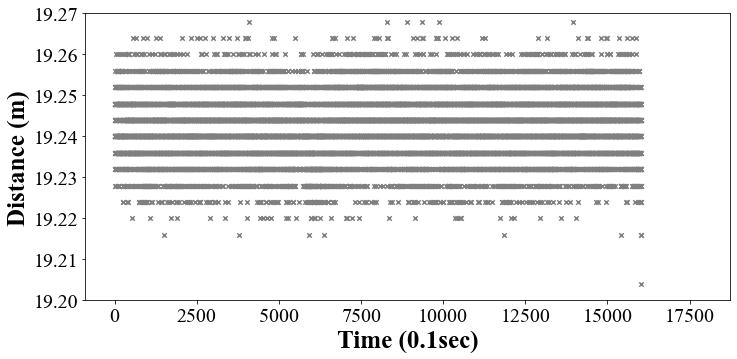

In [52]:
laser_id = 3
azimuth_channel = 1128 
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(19.2,19.27)

plt.show()

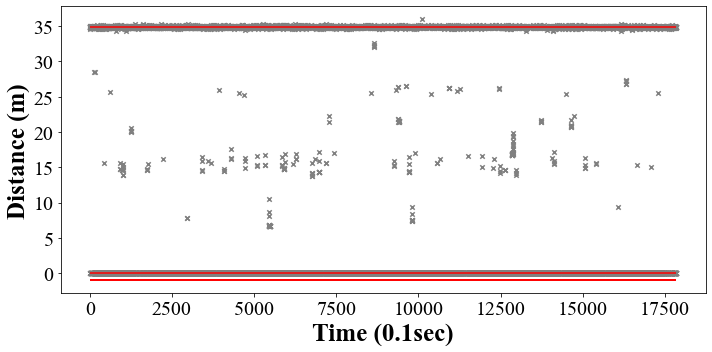

In [17]:
laser_id = 11
azimuth_channel = 1344
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
# plt.ylim(34.5,36)

plt.show()

In [ ]:

temp = 

In [36]:
aggregated_Labeling_map = []
for i in tqdm(range(aggregated_map.shape[0])):
    Td_map = aggregated_map[i]
    Foreground_map = (~(np.abs(Td_map - thred_map) <= 1.5))&(Td_map > 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    aggregated_Labeling_map.append(Labeling_map)
aggregated_Labeling_map = np.array(aggregated_Labeling_map)
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        foreground_ind = aggregated_Labeling_map[:,i,j] != -1
        if foreground_ind.any(): # foreground
            dis_values = aggregated_map[foreground_ind,i,j]
            labels = dbscan.fit_predict(dis_values.reshape(-1,1))
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[1:]
            if len(unique_labels) >= 1: 
                for l in unique_labels:
                    dis = np.mean(dis_values[labels == l])
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = (labels == l).sum()/len(foreground_ind)
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.3,
                                         ransac_n=10,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

 38%|████████████████████████████▉                                                | 12/32 [1:21:34<2:15:58, 407.90s/it]


KeyboardInterrupt: 

In [12]:
temp = aggregated_map[12]
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        dis = temp[i,j]
        XYZ = gen_xyz(dis,i,j)
        points.append(XYZ)
        row_ind.append(i)
        col_ind.append(j)
points = np.array(points)
row_ind = np.array(row_ind)
col_ind = np.array(col_ind)
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\reference.csv',index = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 93.06it/s]


In [56]:
temp = aggregated_map[12].copy()
label_map = np.zeros_like(temp)
label_map[11:12,1340:1343] = 1
pcd = get_pcd_colored(temp,label_map.astype(int))
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_17')

In [32]:
thred_map = thred_map.max(axis = 0)

In [35]:
Td_map = aggregated_map[2]
Foreground_map = (~(np.abs(Td_map - thred_map) <= 1))&(Td_map > 0)
pcd = get_pcd_colored(Td_map,Foreground_map.astype('int'))
draw(pcd)

WebVisualizer(window_uid='window_4')

0.0
1344


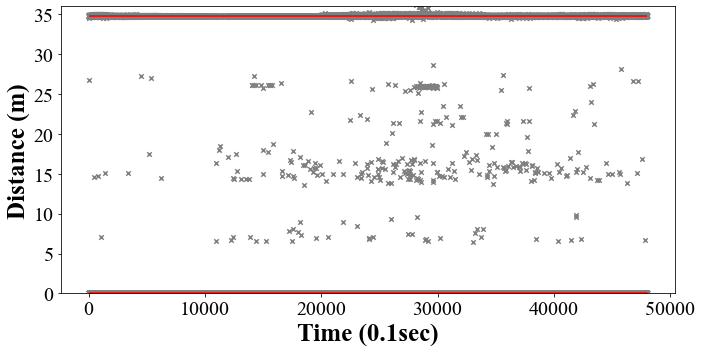

In [64]:
laser_id = 11
azimuth_channel = 1344
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_maps[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_maps.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,36)

# plt.xlim(2000,2400)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

# create dataset

In [ ]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps\2021-12-10-21-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)